In [1]:
import pvdeg

## Adding Points

We are going to add all of the points in the American West to the scenario and downsample by a factor of 1. This will include only half of the points in the latitude axis and half in the longitude axis.

In [2]:
dynamic_points = pvdeg.GeospatialScenario(
    name='dynamic-selection'
)

dynamic_points.addLocation(
    state=['CO', 'UT'],#, 'NM', 'NV', 'ID', 'WY', 'AZ', 'CA', 'OR', 'WA'],
    downsample_factor=1
)

/home/tford/.conda-envs/rpp/lib/python3.10/site-packages/xarray/core/dataset.py:274: UserWarning: The specified chunks separate the stored chunks along dimension "phony_dim_1" starting at index 500. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


### Preview The Scenario's Points

Use `plot_cords` to get a quick snapshot of all coordinates included in the scenario's metadata.

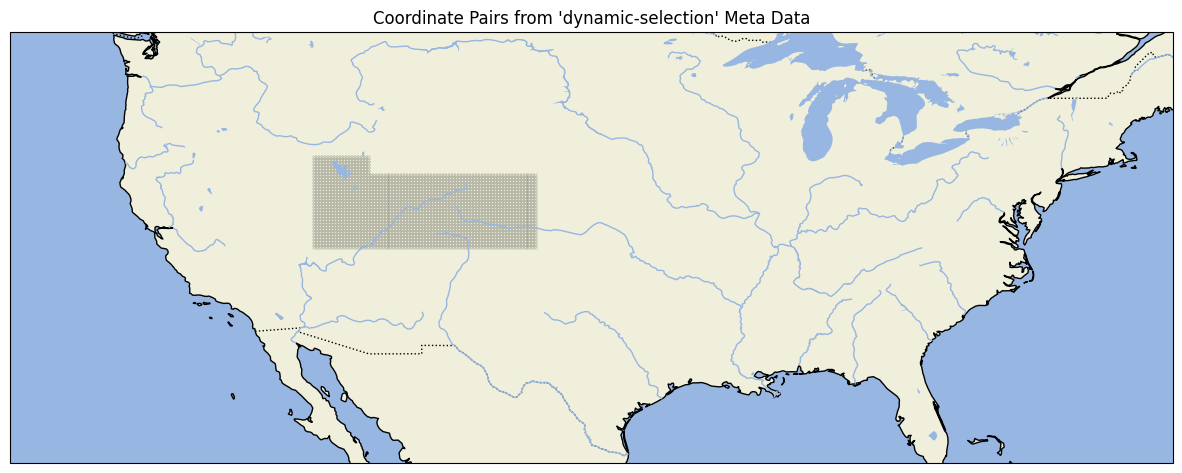

(<Figure size 1500x1000 with 1 Axes>,
 <GeoAxes: title={'center': "Coordinate Pairs from 'dynamic-selection' Meta Data"}>)

In [3]:
dynamic_points.plot_coords(
    coord_1 = [48.574790, -130.253906], # uncomment to see Larger scale view
    coord_2 = [25.482951, -68.027344],
    size = 0.005
)

In [4]:
dynamic_points.meta_data

,latitude,longitude,altitude,tz,country,state,county,wind_height
282901,41.889999,-114.019997,1704,-7,United States,Utah,Box Elder,2
282903,41.810001,-114.019997,2093,-7,United States,Utah,Box Elder,2
282905,41.730000,-114.019997,1880,-7,United States,Utah,Box Elder,2
282907,41.650002,-114.019997,1903,-7,United States,Utah,Box Elder,2
282909,41.570000,-114.019997,1936,-7,United States,Utah,Box Elder,2
...,...,...,...,...,...,...,...,...
559787,37.330002,-102.099998,1139,-7,United States,Colorado,Baca,2
559789,37.250000,-102.099998,1141,-7,United States,Colorado,Baca,2
559791,37.169998,-102.099998,1149,-7,United States,Colorado,Baca,2
559793,37.090000,-102.099998,1096,-7,United States,Colorado,Baca,2


## Downselecting

Using weighted random choices based on elevation we will create a sparse grid from the full metadata for fast calculations. This requires sklearn to be installed but this is not in the `pvdeg` dependency list to you will have to install it seperately.

### Normalization

At each metadata point in our dataset we will calculate a weight based on its changes in elevation compared to its neighbors. The higher the weight, the greater the change in elevation from a point's immediate neighbors. The downselection methods and functions use these weights to randomly select a subset of the datapoints, prefferentially selecting those with higher weights. 

We have some control over which points get selected because all points' weights must be normalized (mapped from 0 to 1) before downselecting. We can apply a function such as $e^x$ or $\log x$ to the weights during normalization. This could help change the distribution of weights that are chosen. This could remove points from the mountains and add them to areas with fewer changes in elevation, or vice versa.

*Note: `pvdeg`'s downselection functions use `numpy.random`, the random seed is not fixed so the result will change between runs.*

### Providing a KdTree

As shown below the lines to create a kdtree are commented out. 


In [6]:
# west_tree = pvdeg.geospatial.meta_KDtree(meta_df=dynamic_points.meta_data)

dynamic_points.downselect_elevation_stochastic(
    #kdtree=west_tree,
    downselect_prop=0.1,
    normalization="linear",
)

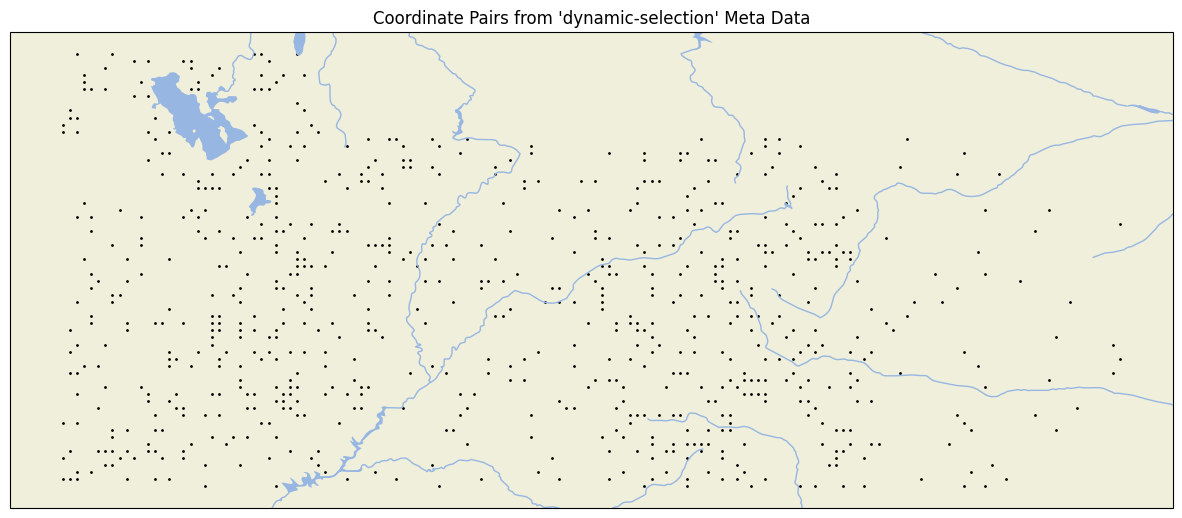

(<Figure size 1500x1000 with 1 Axes>,
 <GeoAxes: title={'center': "Coordinate Pairs from 'dynamic-selection' Meta Data"}>)

In [7]:
dynamic_points.plot_coords()

## Extracting from Scenario

Scenarios provide an easy way to select and downsample geospatial data but we can easily pull out the data to use other `pvdeg` functions on it. In the cell below, we extract the weather data and meta data from the scenario and take only the matching entries from the weather. Then we load the xarray dataset into memory. Previously, it was stored lazily out of memory but we want to do operations on it. (Chunking causes issues when calculating so this eliminates any chunks)

In [ ]:
weather = dynamic_points.weather_data

sub_weather = weather.sel(gid=dynamic_points.meta_data.index) # downselect weather using restricted metadata set

sub_weather = sub_weather.compute() # load into memory

### Geospatial Calculation

Run a standoff calculation on the extracted scenario weather data and scenario meta data.

In [ ]:
# geospatial analysis now

geo = {
    "func": pvdeg.standards.standoff,
    "weather_ds": sub_weather,
    "meta_df": dynamic_points.meta_data,
}

analysis_result = pvdeg.geospatial.analysis(**geo)

### Viewing Results

Inspecting the xarray dataset below shows us that we have many Not a Number (NaN) entries. These occur because we did not provide weather data at every point in the grid of possile latitude-longitude pairs. Expanding the `x` datavariable shows that there are some valid results but these are uncommon.

In [ ]:
analysis_result

## Plotting Sparse Data I

If we try to plot existing data with the current plotting methods exposed by `pvdeg` we will encounter issues. This will produce weak plotting results.

In [ ]:
pvdeg.geospatial.plot_USA(analysis_result['x'])

## Plotting Sparse Data II

Utilize the new `plot_sparse_analysis` function below to interpolate and plot a solid color map. We can use different interpolation schemes but `nearest` and `linear` are best. See [scipy.interpolate.griddata](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html) for more information about interpolation.

In [ ]:
pvdeg.geospatial.plot_sparse_analysis(analysis_result, data_var='x', method='linear')